# EIGO: Evolutionary Image Generation Optimization

This notebook runs the EIGO engine on one user-provided prompt to improve image quality and prompt–image alignment without retraining the generator.

## What it does

* **Generator:** SDXL Turbo (1–4 steps; fast, low cost).
* **Search:** you can choose between the recommended **sep-CMA-ES** or **Adam**.
* **Fitness:** $(F = a\times\hat S_{\text{aest}} + b\times\hat S_{\text{clip}})$ with $(a,b\in[0,1])$.
* **Output:** best image, scores, and the optimized prompt embeddings.

## Typical settings

* Steps: 1–4; Guidance scale: 0; Size: $(512\times512)$.
* Weights: $(a,b\in[0,1])$, where $a+b=1$.
* sep-CMA-ES: population $(\lambda)$, generations $(T)$, step size $(\sigma)$.
* Adam: iterations $(T)$, $(\alpha)$, $((\beta_1,\beta_2))$.

In [12]:
# Parameters
selected_prompt = "an astrounat riding a horse in mars"

optimization_method = "cmaes" #"cmaes" for CMA-ES variants, "adam" for Adam

In [13]:
#general parameters
seed = 42  # Default seed value for reproducibility
prompt_per_categorie = 3  # Number of prompts to sample per category from the dataset
prompt_sample_seed = 42  # Seed for sampling prompts from the dataset
cuda = 0  # GPU device ID to use (e.g., 0 for the first GPU). If no GPU is available, falls back to CPU.
predictor = 2  # Predictor type= 0 for SAM, 1 for LAION V1, 2 for LAION V2
num_inference_steps = 1  # Number of inference steps for the diffusion model during image generation
guidance_scale = 0  # Guidance scale for classifier-free guidance (set to 0 for no guidance)
height = 512  # Height of the generated image in pixels
width = 512  # Width of the generated image in pixels
alpha = 0.7  # Weight for the aesthetic score in the combined fitness function
beta = 0.3  # Weight for the CLIP score in the combined fitness function
max_aesthetic_score = 10  # Maximum possible aesthetic score (used for normalization)
max_clip_score = 0.5  # Maximum possible CLIP score (used for normalization)
model_id = "stabilityai/sdxl-turbo"  # Model ID for the Stable Diffusion XL pipeline
results_folder = "results"  # Folder to save results, including

# CMA-ES specific parameters (if selected)
num_generations = 100  # Number of generations for the CMA-ES optimization process
pop_size = 20  # Population size for CMA-ES optimization
cmaes_variant = "sep"  # Variant of CMA-ES to use: "cmaes" (standard), "sep" (sep-CMA-ES), or "vd" (VD-CMA)
sigma = 0.5  # Initial standard deviation for CMA-ES optimization

# Adam specific parameters (if selected)
num_iterations = 100  # Number of iterations for the Adam optimization process
adam_lr = 5e-3  # Learning rate for the Adam optimizer
adam_weight_decay = 1e-05  # Weight decay for the Adam optimizer
adam_eps = 1e-8  # Epsilon value for numerical stability in the Adam
adam_beta1 = 0.85  # Beta1 parameter for the Adam optimizer
adam_beta2 = 0.98  # Beta2 parameter for the Adam optimizer

In [14]:
# initial setup and function definitions

import sys
import os
import shutil
import yaml
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from diffusers import StableDiffusionXLPipeline
import random
from PIL import Image
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import csv
from pptx import Presentation
from pptx.util import Inches
import cma
from cma.restricted_gaussian_sampler import GaussVDSampler 
from datasets import load_dataset
import clip
import argparse

if predictor == 0:
    predictor_name = 'simulacra'
elif predictor == 1:
    predictor_name = 'laionv1'
elif predictor == 2:
    predictor_name = 'laionv2'
else:
    raise ValueError("Invalid predictor option.")

if optimization_method == "adam":
    method_save_name = "adam"
elif optimization_method == "cmaes":
    if cmaes_variant == "cmaes":
        method_save_name = "cmaes"
    elif cmaes_variant == "sep":
        method_save_name = "sepcmaes"
    elif cmaes_variant == "vd":
        method_save_name = "vdcmae"
    else:
        raise ValueError(f"Unknown CMA-ES variant: {cmaes_variant}")
else:
    raise ValueError(f"Unknown optimization method: {optimization_method}")

OUTPUT_FOLDER = f"{results_folder}/{method_save_name}_clip_{predictor_name}_sdxlturbo_{seed}_a{int(alpha*100)}_b{int(beta*100)}"

# Save the selected prompts and their categories to a text file in the results folder
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Check if a GPU is available and if not, use the CPU
device = "cuda:" + str(cuda) if torch.cuda.is_available() else "cpu"

# Load the SDXL pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
    use_safetensors=True,
).to(device)
pipe.set_progress_bar_config(disable=True)
call_with_grad = pipe.__class__.__call__.__wrapped__.__get__(pipe, pipe.__class__)

clip_model_name = "ViT-L/14"  # CLIP model name
clip_model, clip_preprocess = clip.load(clip_model_name, device=device)

# Initialize the aesthetic model
if predictor == 0:
    from aesthetic_evaluation.src import simulacra_rank_image
    aesthetic_model = simulacra_rank_image.SimulacraAesthetic(device)
    model_name = 'SAM'
elif predictor == 1:
    from aesthetic_evaluation.src import laion_rank_image
    aesthetic_model = laion_rank_image.LAIONAesthetic(device, clip_model=clip_model_name)
    model_name = 'LAIONV1'
elif predictor == 2:
    from aesthetic_evaluation.src import laion_v2_rank_image
    aesthetic_model = laion_v2_rank_image.LAIONV2Aesthetic(device, clip_model=clip_model_name)
    model_name = 'LAIONV2'
else:
    raise ValueError("Invalid predictor option.")

def generate_image_from_embeddings_cmaes(prompt_embeds, pooled_prompt_embeds, seed):
    generator = torch.Generator(device=device).manual_seed(seed)

    out = pipe(
        prompt_embeds              = prompt_embeds,
        pooled_prompt_embeds       = pooled_prompt_embeds,
        guidance_scale             = 0.0,
        num_inference_steps        = num_inference_steps,
        generator                  = generator,
        height                     = height,
        width                      = width,
        output_type               = "pt"
    )["images"]

    image = out.clamp(0, 1).squeeze(0).permute(1, 2, 0)      # HWC
    return image.to(device)

def generate_image_from_embeddings_adam(text_embeddings, seed):
    generator = torch.Generator(device=device).manual_seed(seed)

    prompt_embeds = text_embeddings[0]
    pooled_prompt_embeds = text_embeddings[1]

    out = call_with_grad(
        prompt_embeds              = prompt_embeds,
        pooled_prompt_embeds       = pooled_prompt_embeds,
        guidance_scale             = 0.0,
        num_inference_steps        = num_inference_steps,
        generator                  = generator,
        height                     = height,
        width                      = width,
        output_type               = "pt"
    )["images"]

    image = out.clamp(0, 1).squeeze(0).permute(1, 2, 0)      # HWC
    return image.to(device)

def aesthetic_evaluation(image):
    # image is a tensor of shape [H, W, C]
    # Convert to [N, C, H, W] and ensure it's in float32
    image_input = image.permute(2, 0, 1).to(torch.float32)  # [1, C, H, W]

    if predictor == 0:
        # Simulacra Aesthetic Model
        score = aesthetic_model.predict_from_tensor(image_input)
    elif predictor == 1 or predictor == 2:
        # LAION Aesthetic Predictor V1 and V2
        score = aesthetic_model.predict_from_tensor(image_input)
    else:
        return torch.tensor(0.0, device=device)

    return score

def evaluate_clip_score_cmaes(image_tensor, prompt):
    # Convert the image tensor to a PIL image
    image = (image_tensor * 255).clamp(0, 255).byte()
    image = Image.fromarray(image.cpu().numpy())

    # Preprocess the image
    image_input = clip_preprocess(image).unsqueeze(0).to(device)

    # Tokenize the prompt
    text_input = clip.tokenize([prompt]).to(device)

    # Compute the CLIP embeddings
    image_features = clip_model.encode_image(image_input)
    text_features = clip_model.encode_text(text_input)

    # Normalize the features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute the cosine similarity (CLIP score)
    clip_score = (image_features @ text_features.T)

    return clip_score

# Differentiable CLIP score evaluation for Adam
_CLIP_MEAN = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1,3,1,1)
_CLIP_STD  = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1,3,1,1)
def evaluate_clip_score_adam(image_tensor, text_features):
    clip_model.eval()

    # --- differentiable preprocess (no PIL, no .byte) ---
    img = image_tensor.permute(2,0,1).unsqueeze(0)            # [1,C,H,W]
    img = img.to(device=device, dtype=torch.float32)
    img = F.interpolate(img, size=(224,224), mode="bicubic", align_corners=False)
    mean = _CLIP_MEAN.to(img.device, img.dtype)
    std  = _CLIP_STD.to(img.device, img.dtype)
    img = (img - mean) / std

    # Encode image WITH grad (through CLIP image tower)
    image_features = clip_model.encode_image(img).float()
    image_features = F.normalize(image_features, dim=-1, eps=1e-6)

    sim = (image_features @ text_features.T).squeeze()  # scalar
    return sim

def format_time(seconds):
    seconds = int(seconds)
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    if hours > 0:
        return f"{hours}h {minutes}m {seconds}s"
    elif minutes > 0:
        return f"{minutes}m {seconds}s"
    else:
        return f"{seconds}s"

def evaluate(input_embedding, seed, embedding_shape, selected_prompt, save_path=None):
    # x is a NumPy array representing the embedding vector
    # Convert it to a torch tensor

    # Reshape the embedding to the original shape
    split = np.prod(embedding_shape[0])
    pe  = torch.tensor(input_embedding[:split],  dtype=torch.float32, device=device).view(embedding_shape[0])
    ppe = torch.tensor(input_embedding[split:], dtype=torch.float32, device=device).view(embedding_shape[1])

    with torch.no_grad():
        image = generate_image_from_embeddings_cmaes(pe, ppe, seed)

        aesthetic_score = aesthetic_evaluation(image).item()
        clip_score = evaluate_clip_score_cmaes(image, selected_prompt).item()
    # CMA-ES minimizes the function, so we need to invert the score if higher is better

    fitness_1 = alpha*aesthetic_score/max_aesthetic_score
    fitness_2 = beta*clip_score/max_clip_score

    fitness = fitness_1 + fitness_2

    if save_path is not None:
        # Save the generated image
        image_np = image.detach().clone().cpu().numpy()
        image_np = (image_np * 255).astype(np.uint8)
        pil_image = Image.fromarray(image_np)
        pil_image.save(save_path)

    return -fitness, aesthetic_score, clip_score, fitness_1, fitness_2 


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


In [15]:
#CMA-ES optimization loop definition
def main_cmaes(seed, selected_prompt):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    print(f"Selected prompt: {selected_prompt}")

    results_folder = f"{OUTPUT_FOLDER}/results_{model_name}_{seed}"
    os.makedirs(results_folder, exist_ok=True)

    with torch.no_grad():
        (prompt_embeds,
        negative_prompt_embeds,
        pooled_prompt_embeds,
        negative_pooled_prompt_embeds) = pipe.encode_prompt(
                selected_prompt,
                negative_prompt="",                 
                device=device,
                num_images_per_prompt=1,
                do_classifier_free_guidance=False
        )

    # Set CMA-ES options
    es_options = {
        'seed': seed,
        'popsize': pop_size,
        'maxiter': num_generations,
        'verb_filenameprefix': results_folder + '/outcmaes',  # Save logs
        'verb_log': 0,  # Disable log output
        'verbose': -9,  # Suppress console output
    }

    if cmaes_variant == "cmaes":
        print("Using standard CMA-ES")
    elif cmaes_variant == "sep":
        print("Using sep-CMA-ES")
        es_options['CMA_diagonal'] = True
    elif cmaes_variant == "vd":
        print("Using VD-CMA-ES")
        es_options = GaussVDSampler.extend_cma_options(es_options)
    else:
        raise ValueError(f"Unknown CMA-ES variant: {cmaes_variant}")

    trainable_params_init = torch.cat([
        prompt_embeds.flatten(),
        pooled_prompt_embeds.flatten()
        ]).cpu().numpy()

    sh_prompt  = prompt_embeds.shape         
    sh_pooled  = pooled_prompt_embeds.shape  

    text_embeddings_init_shape = [sh_prompt, sh_pooled]

    es = cma.CMAEvolutionStrategy(trainable_params_init, sigma, es_options)

    with torch.no_grad():
        initial_image = generate_image_from_embeddings_cmaes(prompt_embeds.clone(), pooled_prompt_embeds.clone(), seed)
        image_np = initial_image.detach().clone().cpu().numpy()
        image_np = (image_np * 255).astype(np.uint8)
        pil_image = Image.fromarray(image_np)
        pil_image.save(f"{results_folder}/it_0.png")

        initial_fitness, initial_aesthetic_score, initial_clip_score, initial_fitness_1, initial_fitness_2 = evaluate(trainable_params_init, seed, text_embeddings_init_shape, selected_prompt)

    time_list = [0]
    best_aesthetic_score_overall = initial_aesthetic_score
    best_clip_score_overall = initial_clip_score
    best_fitness_overall = initial_fitness
    best_text_embeddings_overall = trainable_params_init

    start_time = time.time()
    generation = 0

    max_fit_list = [-initial_fitness]
    avg_fit_list = [-initial_fitness]
    std_fit_list = [0]

    max_aesthetic_score_list = [initial_aesthetic_score]
    avg_aesthetic_score_list = [initial_aesthetic_score]
    std_aesthetic_score_list = [0]

    max_clip_score_list = [initial_clip_score]
    avg_clip_score_list = [initial_clip_score]
    std_clip_score_list = [0]

    max_fitness_1_list = [initial_fitness_1]
    avg_fitness_1_list = [initial_fitness_1]
    std_fitness_1_list = [0]

    max_fitness_2_list = [initial_fitness_2]
    avg_fitness_2_list = [initial_fitness_2]
    std_fitness_2_list = [0]

    while not es.stop():
        print(f"Generation {generation+1}/{num_generations}")

        os.makedirs(results_folder+"/gen_%d" % (generation+1), exist_ok=True)

        # Ask for new candidate solutions
        solutions = es.ask()
        # Evaluate candidate solutions
        tmp_fitnesses = []
        tmp_fitness_1 = []
        tmp_fitness_2 = []
        aesthetic_scores = []
        clip_scores = []

        ind_id = 1
        for x in solutions:
            save_path = results_folder + "/gen_%d/id_%d.png" % (generation+1, ind_id)
            fitness, aesthetic_score, clip_score, fitness_1, fitness_2 = evaluate(x, seed, text_embeddings_init_shape, selected_prompt, save_path)
            tmp_fitnesses.append(fitness)
            tmp_fitness_1.append(fitness_1)
            tmp_fitness_2.append(fitness_2)
            aesthetic_scores.append(aesthetic_score)
            clip_scores.append(clip_score)
            ind_id += 1
        # Tell CMA-ES the fitnesses
        es.tell(solutions, tmp_fitnesses)

        # Record statistics
        fitnesses = [-f for f in tmp_fitnesses]  # Convert back to positive scores

        max_fit = max(fitnesses)
        avg_fit = np.mean(fitnesses)
        std_fit = np.std(fitnesses)

        max_fit_list.append(max_fit)
        avg_fit_list.append(avg_fit)
        std_fit_list.append(std_fit)

        max_aesthetic_score = max(aesthetic_scores)
        avg_aesthetic_score = np.mean(aesthetic_scores)
        std_aesthetic_score = np.std(aesthetic_scores)

        max_aesthetic_score_list.append(max_aesthetic_score)
        avg_aesthetic_score_list.append(avg_aesthetic_score)
        std_aesthetic_score_list.append(std_aesthetic_score)

        max_clip_score = max(clip_scores)
        avg_clip_score = np.mean(clip_scores)
        std_clip_score = np.std(clip_scores)

        max_clip_score_list.append(max_clip_score)
        avg_clip_score_list.append(avg_clip_score)
        std_clip_score_list.append(std_clip_score)

        max_fitness_1 = max(tmp_fitness_1)
        avg_fitness_1 = np.mean(tmp_fitness_1)
        std_fitness_1 = np.std(tmp_fitness_1)

        max_fitness_1_list.append(max_fitness_1)
        avg_fitness_1_list.append(avg_fitness_1)
        std_fitness_1_list.append(std_fitness_1)

        max_fitness_2 = max(tmp_fitness_2)
        avg_fitness_2 = np.mean(tmp_fitness_2)
        std_fitness_2 = np.std(tmp_fitness_2)

        max_fitness_2_list.append(max_fitness_2)
        avg_fitness_2_list.append(avg_fitness_2)
        std_fitness_2_list.append(std_fitness_2)

        # Get best solution so far
        best_x = es.result.xbest
        best_fitness = -es.result.fbest  # Convert back to positive score

        with torch.no_grad():
            # Generate and save the best image
            split = np.prod(text_embeddings_init_shape[0])
            best_pe  = torch.tensor(best_x[:split],  dtype=torch.float32, device=device).view(text_embeddings_init_shape[0])
            best_ppe = torch.tensor(best_x[split:], dtype=torch.float32, device=device).view(text_embeddings_init_shape[1])
            best_image = generate_image_from_embeddings_cmaes(best_pe, best_ppe, seed)
            image_np = best_image.detach().clone().cpu().numpy()
            image_np = (image_np * 255).astype(np.uint8)
            pil_image = Image.fromarray(image_np)
            pil_image.save(results_folder + "/best_%d.png" % (generation+1))

        if best_fitness > best_fitness_overall:
            best_fitness_overall = best_fitness
            best_text_embeddings_overall = best_x

        generation += 1

        elapsed_time = time.time() - start_time
        generations_done = generation
        generations_left = num_generations - generations_done
        average_time_per_generation = elapsed_time / generations_done
        estimated_time_remaining = average_time_per_generation * generations_left

        formatted_time_remaining = format_time(estimated_time_remaining)

        time_list.append(elapsed_time)

        # Save the metrics
        results = pd.DataFrame({
            "generation": list(range(0, generation + 1)),
            "prompt": [selected_prompt] + [''] * generation,
            "avg_fitness": avg_fit_list,
            "std_fitness": std_fit_list,
            "max_fitness": max_fit_list,
            "avg_aesthetic_score": avg_aesthetic_score_list,
            "std_aesthetic_score": std_aesthetic_score_list,
            "max_aesthetic_score": max_aesthetic_score_list,
            "avg_clip_score": avg_clip_score_list,
            "std_clip_score": std_clip_score_list,
            "max_clip_score": max_clip_score_list,
            "elapsed_time": time_list
        })

        results.to_csv(f"{results_folder}/fitness_results.csv", index=False, na_rep='nan')

        save_plot_results(results, results_folder)

        # Print stats
        print(f"Generation {generation}/{num_generations}: Max fitness: {max_fit}, Avg fitness: {avg_fit}, Max aesthetic score: {max_aesthetic_score}, Avg aesthetic score: {avg_aesthetic_score}, Max clip score: {max_clip_score}, Avg clip score: {avg_clip_score}, Estimated time remaining: {formatted_time_remaining}")

    # Save the overall best image
    with torch.no_grad():
        split = np.prod(text_embeddings_init_shape[0])
        best_overall_pe  = torch.tensor(best_text_embeddings_overall[:split],  dtype=torch.float32, device=device).view(text_embeddings_init_shape[0])
        best_overall_ppe = torch.tensor(best_text_embeddings_overall[split:], dtype=torch.float32, device=device).view(text_embeddings_init_shape[1])
        best_image = generate_image_from_embeddings_cmaes(best_overall_pe, best_overall_ppe, seed)
    best_image_np = best_image.detach().cpu().numpy()
    best_image_np = (best_image_np * 255).astype(np.uint8)
    pil_image = Image.fromarray(best_image_np)
    pil_image.save(f"{results_folder}/best_all.png")

    return results_folder

def plot_mean_std(x_axis, m_vec, std_vec, description, title=None, y_label=None, x_label=None):
    lower_bound = [M_new - Sigma for M_new, Sigma in zip(m_vec, std_vec)]
    upper_bound = [M_new + Sigma for M_new, Sigma in zip(m_vec, std_vec)]

    plt.plot(x_axis, m_vec, '--', label=description + " Avg.")
    plt.fill_between(x_axis, lower_bound, upper_bound, alpha=.3, label=description + " Avg. ± SD")
    if title is not None:
        plt.title(title)
    if y_label is not None:
        plt.ylabel(y_label)
    if x_label is not None:
        plt.xlabel(x_label)

def save_plot_results(results, results_folder):
    # Plot main fitness evolution
    plt.figure(figsize=(10, 6))  # Increase figure size
    plot_mean_std(results['generation'], results['avg_fitness'], results['std_fitness'], "Fitness")
    plt.plot(results['generation'], results['max_fitness'], 'r-', label="Best Fitness")
    plt.ylim(0, 1.1)
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.grid()
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside the plot
    plt.tight_layout()  # Adjust layout
    plt.savefig(results_folder + "/fitness_evolution.png")
    plt.close()

    # Plot aesthetic score evolution
    plt.figure(figsize=(10, 6))  # Increase figure size
    plot_mean_std(results['generation'], results['avg_aesthetic_score'], results['std_aesthetic_score'], "Population")
    plt.plot(results['generation'], results['max_aesthetic_score'], 'r-', label="Best")
    plt.ylim(0, 10)
    plt.xlabel('Generation')
    plt.ylabel('Aesthetic Score')
    plt.grid()
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside the plot
    plt.tight_layout()  # Adjust layout
    plt.savefig(results_folder + "/aesthetic_score_evolution.png")
    plt.close()

    # Plot clip score evolution
    plt.figure(figsize=(10, 6))  # Increase figure size
    plot_mean_std(results['generation'], results['avg_clip_score'], results['std_clip_score'], "Population")
    plt.plot(results['generation'], results['max_clip_score'], 'r-', label="Best")
    plt.ylim(0, 0.6)
    plt.xlabel('Generation')
    plt.ylabel('CLIP Score')
    plt.grid()
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside the plot
    plt.tight_layout()  # Adjust layout
    plt.savefig(results_folder + "/clip_score_evolution.png") 
    plt.close()   

In [16]:
#Adam optimization loop definition

def main_adam(seed, selected_prompt):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    print(f"Selected prompt: {selected_prompt}")

    results_folder = f"{OUTPUT_FOLDER}/results_{model_name}_{seed}"
    os.makedirs(results_folder, exist_ok=True)

    # Text features don't depend on your params; compute w/o grad
    with torch.no_grad():
        text_tokens = clip.tokenize([selected_prompt]).to(device)
        text_features = clip_model.encode_text(text_tokens).float()
        text_features = F.normalize(text_features, dim=-1, eps=1e-6)

    (prompt_embeds,
        negative_prompt_embeds,
        pooled_prompt_embeds,
        negative_pooled_prompt_embeds) = pipe.encode_prompt(
                selected_prompt,
                negative_prompt="",                 
                device=device,
                num_images_per_prompt=1,
                do_classifier_free_guidance=False
    )
    text_embeddings_init = [prompt_embeds.detach().clone(), pooled_prompt_embeds.detach().clone()]
    text_embeddings = [torch.nn.Parameter(prompt_embeds.clone()), torch.nn.Parameter(pooled_prompt_embeds.clone())]

    with torch.no_grad():
        initial_image = generate_image_from_embeddings_adam(text_embeddings_init, seed)
        image_np = initial_image.detach().clone().cpu().numpy()
        image_np = (image_np * 255).astype(np.uint8)
        pil_image = Image.fromarray(image_np)
        pil_image.save(f"{results_folder}/it_0.png")

    aesthetic_score = aesthetic_evaluation(initial_image)

    clip_score = evaluate_clip_score_adam(initial_image, text_features)

    initial_combined_score = alpha * aesthetic_score / max_aesthetic_score + beta * clip_score / max_clip_score
    initial_combined_loss = 1 - initial_combined_score

    combined_score_list = [initial_combined_score.item()]
    combined_loss_list = [initial_combined_loss.item()]
    time_list = [0]
    best_score = initial_combined_score
    best_text_embeddings = text_embeddings_init.copy()

    optimizer = torch.optim.Adam(text_embeddings, lr=adam_lr, betas=(adam_beta1,adam_beta2), weight_decay=adam_weight_decay, eps=adam_eps)  

    start_time = time.time()

    # Add lists to store the metrics
    aesthetic_score_list = [aesthetic_score.item()]
    clip_score_list = [clip_score.item()]

    for iteration in range(1, num_iterations + 1):
        print(f"Iteration {iteration}/{num_iterations}")

        optimizer.zero_grad()

        #with torch.autocast(device_type=device, dtype=torch.float16):
        image = generate_image_from_embeddings_adam(text_embeddings, seed)
        aesthetic_score = aesthetic_evaluation(image)
        clip_score = evaluate_clip_score_adam(image, text_features)
        combined_score = alpha * aesthetic_score / max_aesthetic_score + beta * clip_score / max_clip_score
        combined_loss = 1 - combined_score

        # Calculate gradients
        combined_loss.backward()
        # Update parameters
        optimizer.step()

        # Append metrics to their respective lists
        aesthetic_score_list.append(aesthetic_score.item())
        clip_score_list.append(clip_score.item())

        if combined_score.item() > best_score:
            best_score = combined_score.item()
            best_text_embeddings = text_embeddings.copy()

        combined_score_list.append(combined_score.item())
        combined_loss_list.append(combined_loss.item())

        image_np = image.detach().clone().cpu().numpy()
        image_np = (image_np * 255).astype(np.uint8)
        pil_image = Image.fromarray(image_np)
        pil_image.save(f"{results_folder}/it_{iteration}.png")

        elapsed_time = time.time() - start_time
        iterations_done = iteration
        iterations_left = num_iterations - iteration
        average_time_per_iteration = elapsed_time / iterations_done
        estimated_time_remaining = average_time_per_iteration * iterations_left

        formatted_time_remaining = format_time(estimated_time_remaining)

        time_list.append(elapsed_time)

        # Save metrics to the results DataFrame
        results = pd.DataFrame({
            "iteration": list(range(0, iteration + 1)),
            "prompt": [selected_prompt] + [''] * iteration,
            "combined_score": combined_score_list,
            "combined_loss": combined_loss_list,
            "aesthetic_score": aesthetic_score_list,
            "clip_score": clip_score_list,
            "elapsed_time": time_list
        })

        results.to_csv(f"{results_folder}/score_results.csv", index=False, na_rep='nan')

        # Plot and save the fitness evolution
        plot_results(results, results_folder)

        # Print stats
        print(f"Iteration {iteration}/{num_iterations}: Combined Score: {combined_score.item()}, Aesthetic Score: {aesthetic_score.item()}, CLIP Score: {clip_score.item()}, Estimated time remaining: {formatted_time_remaining}")

    # Save the overall best image
    with torch.no_grad():
        best_image = generate_image_from_embeddings_adam(best_text_embeddings, seed)
    best_image_np = best_image.detach().cpu().numpy()
    best_image_np = (best_image_np * 255).astype(np.uint8)
    pil_image = Image.fromarray(best_image_np)
    pil_image.save(f"{results_folder}/best_all.png")

    return results_folder

def plot_results(results, results_folder):
    plt.figure(figsize=(10, 6))  # Increase figure size
    plt.plot(results['iteration'], results['aesthetic_score'], label="Aesthetic Score")
    plt.xlabel('Iteration')
    plt.ylabel('Aesthetic Score')
    plt.title('Aesthetic Score Evolution')
    plt.grid()
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside the plot
    plt.tight_layout()  # Adjust layout
    plt.savefig(results_folder + "/aesthetic_evolution.png")
    plt.close()

    plt.figure(figsize=(10, 6))  # Increase figure size
    plt.plot(results['iteration'], results['clip_score'], label="CLIP Score")
    plt.xlabel('Iteration')
    plt.ylabel('CLIP Score')
    plt.title('CLIP Score Evolution')
    plt.grid()
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside the plot
    plt.tight_layout()  # Adjust layout
    plt.savefig(results_folder + "/clip_evolution.png")
    plt.close()

    # Plot all losses in one plot
    plt.figure(figsize=(10, 6))  # Increase figure size
    plt.plot(results['iteration'], results['combined_loss'], label="Combined Loss")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.grid()
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside the plot
    plt.tight_layout()  # Adjust layout
    plt.savefig(results_folder + "/loss_evolution.png")
    plt.close()

def plot_mean_std(x_axis, m_vec, std_vec, description, title=None, y_label=None, x_label=None):
    lower_bound = [M_new - Sigma for M_new, Sigma in zip(m_vec, std_vec)]
    upper_bound = [M_new + Sigma for M_new, Sigma in zip(m_vec, std_vec)]

    plt.plot(x_axis, m_vec, '--', label=description + " Avg.")
    plt.fill_between(x_axis, lower_bound, upper_bound, alpha=.3, label=description + " Avg. ± SD")
    if title is not None:
        plt.title(title)
    if y_label is not None:
        plt.ylabel(y_label)
    if x_label is not None:
        plt.xlabel(x_label)

In [17]:
#Optimization execution
from IPython.display import Image as IPythonImage

if optimization_method == "cmaes":
    results_folder = main_cmaes(seed, selected_prompt)
elif optimization_method == "adam":
    results_folder = main_adam(seed, selected_prompt)


Selected prompt: an astrounat riding a horse in mars
Using sep-CMA-ES


Generation 1/100
Generation 1/100: Max fitness: 0.6628142642974854, Avg fitness: 0.6354112458229064, Max aesthetic score: 6.997374534606934, Avg aesthetic score: 6.624370336532593, Max clip score: 0.313232421875, Avg clip score: 0.286175537109375, Estimated time remaining: 13m 52s
Generation 2/100
Generation 2/100: Max fitness: 0.6813847255706786, Avg fitness: 0.6415534708499908, Max aesthetic score: 7.03456974029541, Avg aesthetic score: 6.700763869285583, Max clip score: 0.31494140625, Avg clip score: 0.2875, Estimated time remaining: 14m 4s
Generation 3/100
Generation 3/100: Max fitness: 0.6768988847732544, Avg fitness: 0.6509161078929901, Max aesthetic score: 7.09395170211792, Avg aesthetic score: 6.82761013507843, Max clip score: 0.317626953125, Avg clip score: 0.2883056640625, Estimated time remaining: 13m 47s
Generation 4/100
Generation 4/100: Max fitness: 0.6749180173873901, Avg fitness: 0.6563452613353729, Max aesthetic score: 7.170375823974609, Avg aesthetic score: 6.91866695

Initial image


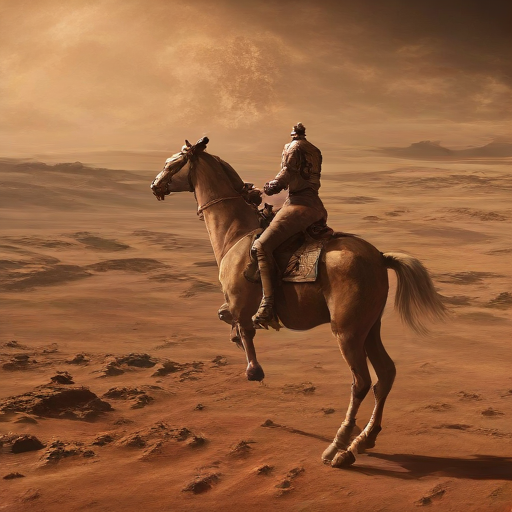

In [18]:
print("Initial image")
display(IPythonImage(filename=results_folder+"/it_0.png"))

Best image


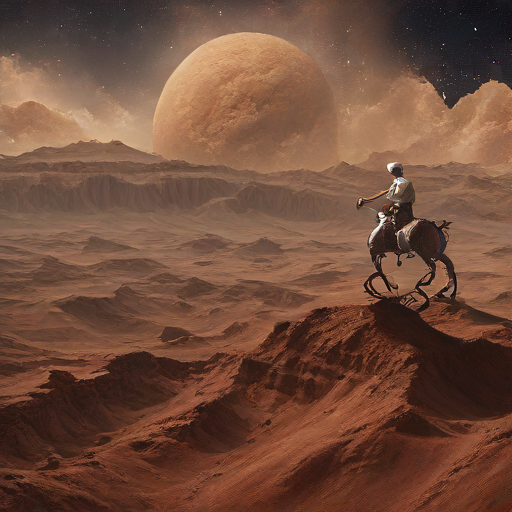

In [19]:
print("Best image")
display(IPythonImage(filename=results_folder+"/best_all.png"))

Aesthetic evolution


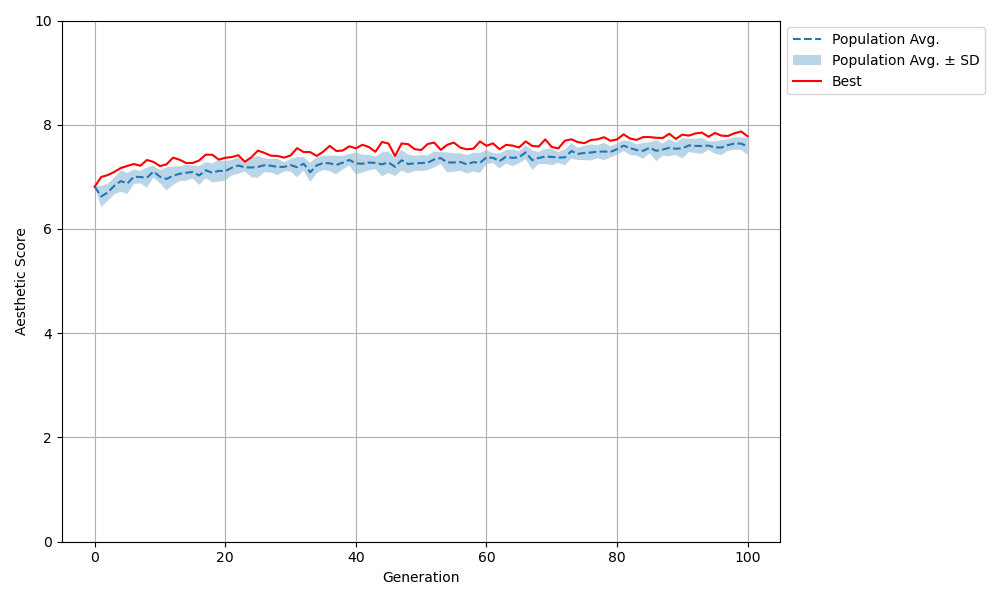

In [20]:
print("Aesthetic evolution")
if optimization_method == "cmaes":
    display(IPythonImage(filename=results_folder+"/aesthetic_score_evolution.png"))
elif optimization_method == "adam":
    display(IPythonImage(filename=results_folder+"/aesthetic_evolution.png"))

CLIPScore evolution


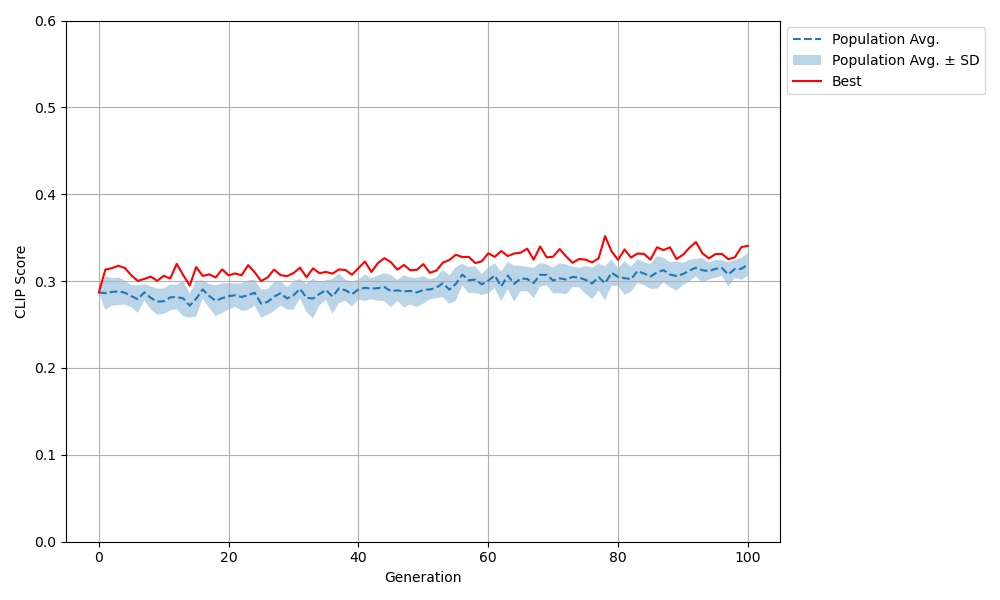

In [21]:
print("CLIPScore evolution")
if optimization_method == "cmaes":
    display(IPythonImage(filename=results_folder+"/clip_score_evolution.png"))
elif optimization_method == "adam":
    display(IPythonImage(filename=results_folder+"/clip_evolution.png"))

Fitness evolution


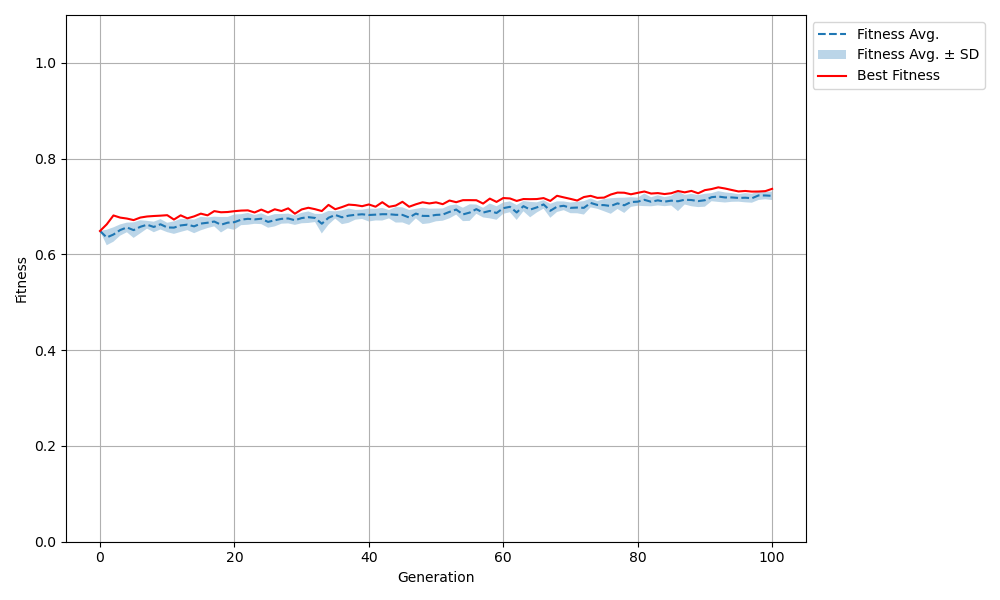

In [22]:
if optimization_method == "cmaes":
    print("Fitness evolution")
    display(IPythonImage(filename=results_folder+"/fitness_evolution.png"))
elif optimization_method == "adam":
    print("Loss evolution")
    display(IPythonImage(filename=results_folder+"/loss_evolution.png"))